# Debugging MCMC

In the last notebook 'posterior-functions', we reached the point of running MCMC but quickly ran in to the difficulty potentially caused by not having a likelihood function that accurately reflects likelihood. So we are here going to systematically study that, and potential solutions.

Steps:

- Import specific patient data
- find the simulated annealling parameters for that patient
- directly compare the model and data for all regions just to have a look
- Attempt MCMC using the pearson cost function, starting at the simulated annealling position. 
- now, can we design a better cost function?

In [5]:
import sys, os
sys.path.append("..")

from inverse import bayesian_funcs as bf
from inverse import priors as pr
from preprocess import preprocess as pp
from preprocess import permute
from brain import Brain
from utils import path as pth
from utils import functions

#generic modules
import matplotlib.pyplot as mpl
%matplotlib inline
from scipy.io import loadmat
import numpy as np
from scipy import stats
import math
import pandas as pd

## Finding a set of parameters with corresponding patient identifier.

In [3]:
HCP_params_path = '/Users/Megan/RajLab/BRAIN/SCFC-spectral-python/SCFC/data/SCFC_opparam_HCP.mat'
HCPdata = loadmat(HCP_params_path)

In [9]:
df = pd.DataFrame(HCPdata['output'][0])
df2 = df.drop(columns = ['feval','simannealmsg', 'cfevals'])

In [10]:
df2.head()

,subjname,param
0,[8002.101],"[[0.012], [0.005], [0.5], [5.0], [4.0], [1.0],..."
1,[8008.101],"[[0.011934858833523522], [0.007416371455534797..."
2,[8012.101],"[[0.015953676157214023], [0.008954110012403716..."
3,[8027.101],"[[0.016012950820885972], [0.008461467268632639..."
4,[8028.101],"[[0.01565266891377659], [0.0061132652979348796..."


Let's work with the second subject, to make a change from always working with the first in the list. This is patient '8008.101'

In [13]:
param_start = df2.iloc[[1]]

In [24]:
param_start = param_start['param'].values[0]

## Getting the corresponding patient MEG spectrum

In [25]:
FMEG_path = '/Users/Megan/RajLab/BRAIN/SCFC-spectral-python/SCFC/data/freqMEGdata.mat' #insert appropriate path here.
label_filepath = '/Users/Megan/RajLab/BRAIN/SCFC-spectral-python/SCFC/dictionaries/OrderingAlphabetical_68ROIs.txt'
data = loadmat(FMEG_path)

In [33]:
data['freqMEGdata'].shape

(1, 39)

In [34]:
data['freqMEGdata'][0][1]

(array([[207.40555223, 112.04169602,  78.68421254, ...,  41.9649025 ,
         36.62201405,  28.79667679],
       [104.81741115, 111.23873788,  98.25091692, ...,  21.61562307,
         13.51546009,   5.91221225],
       [136.37605662, 105.40663604, 126.90454504, ...,  18.85706211,
          8.29085297,   3.71796781],
       ...,
       [249.01677792, 199.19023534, 240.82173539, ...,  17.9340072 ,
         10.85342461,   6.82913285],
       [ 39.6609094 ,  52.78331371,  94.21488461, ...,   9.23975365,
          5.00805492,   3.27270123],
       [ 92.57309715, 134.75379333, 245.78013457, ...,  20.93967675,
         14.36975514,   9.50631562]]), array(['8008.101'], dtype='<U8'))

This is the data corresponding to the correct patient. Let's extract the spectrum.

In [36]:
pat_data = data['freqMEGdata'][0][1][0]

In [37]:
pat_data.shape

(68, 40)

68 brain regions, 40 frequency points each. Let's give each of the brain regions a key (make a dictionary of data) and then order them according to the standard we are using for the brain class (HCP).

In [38]:
pat_dict = pp.add_key_to_matdata(label_filepath, pat_data)
orderfile = '/Users/Megan/RajLab/BRAIN/SCFC-spectral-python/SCFC/dictionaries/HCP_list.h5'
FMEGdownsample = permute.order_dict(pat_dict, orderfile)

## Making the model to match

In [39]:
fmin = 2 # 2Hz - 45Hz signal range
fmax = 45
fvec = np.linspace(fmin,fmax,40)
newbrain = Brain.Brain()
hcp_dir = pth.get_sibling_path('data') # connectome information is in /data/ dir
newbrain.add_connectome(hcp_dir) # Use default files in /data/
newbrain.reorder_connectome(newbrain.connectome, newbrain.distance_matrix)
newbrain.bi_symmetric_c()
newbrain.reduce_extreme_dir()

Make the parameter set 'param_start' in to a dictionary to pass to the model.

In [40]:
tau_e, tau_i, alpha, speed, gei, gii, tauC = param_start

In [53]:
param_start

array([[1.19348588e-02],
       [7.41637146e-03],
       [9.67023304e-01],
       [1.44790558e+01],
       [3.95527275e+00],
       [1.79503011e+00],
       [8.75783847e-03]])

In [46]:
parameters = {'tau_e':tau_e,
                       'tau_i':tau_i,
                       'alpha':alpha,
                       'speed':speed,
                       'gei':gei,
                       'gii':gii,
                       'tauC':tauC
                       }

In [48]:
from forward import runforward as rf
freq_model = rf.run_forward(newbrain, parameters, fvec)

## Inspect model and data

Remember, this was the parameter set that the simulated annealing gave as returning the best fit. 

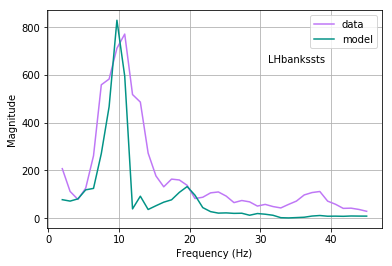

In [63]:
fig = mpl.figure(num=5, figsize = (6,4))
mpl.plot(fvec,FMEGdownsample['LHbankssts'], '-', color= 'xkcd:light purple', label = 'data')
mpl.plot(fvec,70*np.abs(freq_model[0,:]),'-', color= 'xkcd:teal', label = 'model')
mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude')
mpl.text(31,650,'LHbankssts')
ax = mpl.gca()
ax.legend()
fig.savefig("Patient8008_101.pdf", bbox_inches='tight')

Let's plot this quickly for all the regions (automatically finding a scaling factor) and take a look at how well the fit is working for individual regions.

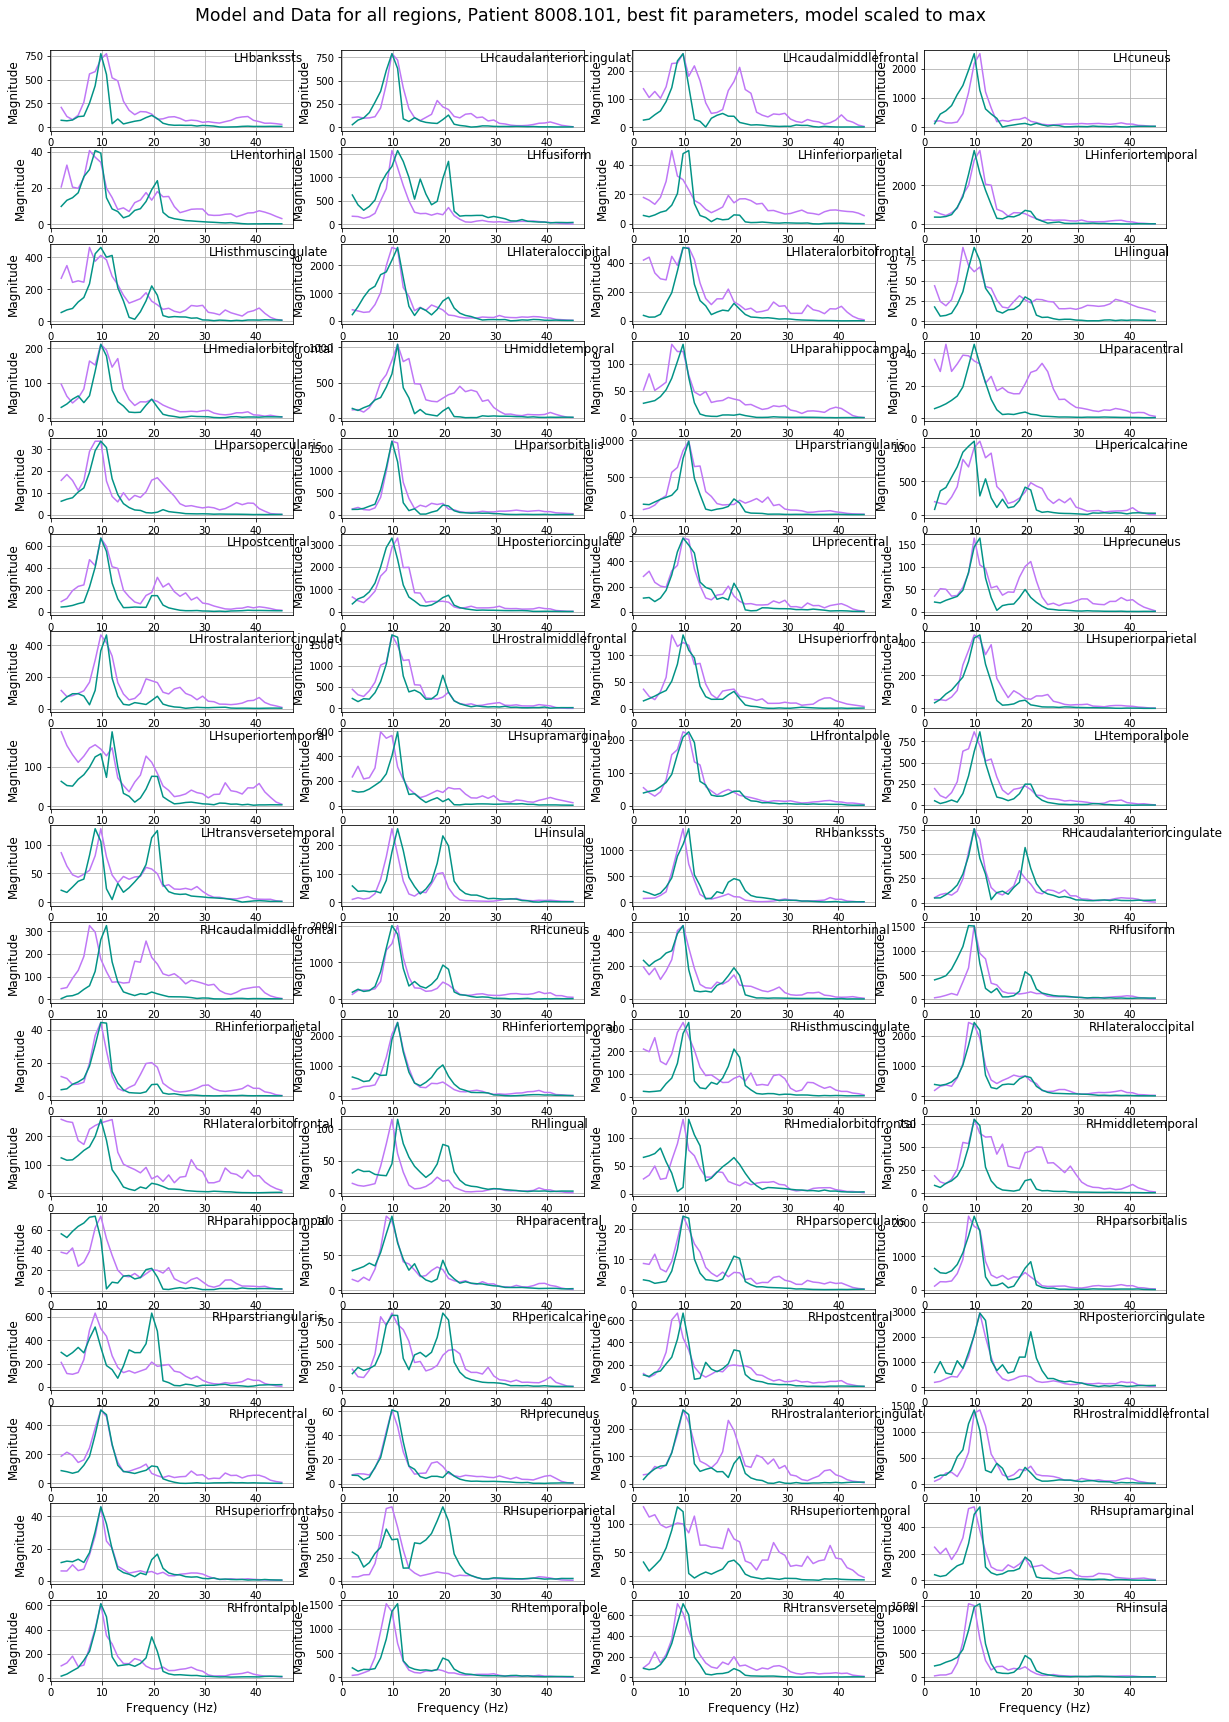

In [66]:
fig1, axes1 = mpl.subplots(17,4, figsize = (20,30))
ax1 = axes1.ravel()
fig1.suptitle('Model and Data for all regions, Patient 8008.101, best fit parameters, model scaled to max', fontsize = 'xx-large', y = 0.9)
i = 0
scale = np.empty(68)

for key in FMEGdownsample.keys():
    mpl.sca(ax1[i])
    mpl.plot(fvec,FMEGdownsample[key], '-', color= 'xkcd:light purple', label = 'data')
    scale[i] = max(FMEGdownsample[key])/max(np.abs(freq_model[i,:]))
    mpl.plot(fvec,scale[i]*np.abs(freq_model[i,:]),'-', color= 'xkcd:teal', label = 'model')
    ax1[i].grid(True)
    ax1[i].set_ylabel('Magnitude', fontsize = 'large')
    ax1[i].text(0.9, 0.9,key,
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax1[i].transAxes, fontsize = 'large')
    ax1[i].set_xlabel('Frequency (Hz)', fontsize = 'large')
    #ax3[i].axvline(x=param_lower[i], color='r', linestyle='dashed', linewidth=2)
    #ax3[i].axvline(x=param_upper[i], color='r', linestyle='dashed', linewidth=2)
    i += 1
#mpl.sca(ax3[7])
#ax3[7].set_visible(False)
fig1.savefig("Patient8008_101_allregions.pdf", bbox_inches='tight')

OK, now let's take the mean across all regions in both the case of the model and the data. 

In [70]:
FMEGarray = np.empty((68,40))
i = 0
for key in FMEGdownsample.keys():
    FMEGarray[i,:] = FMEGdownsample[key]
    i += 1

In [71]:
FMEGmean = np.mean(FMEGarray, axis = 0)

In [73]:
modelmean = np.mean(freq_model, axis = 0)

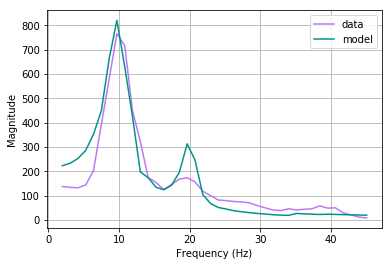

In [76]:
fig2 = mpl.figure(num=5, figsize = (6,4))
mpl.plot(fvec,FMEGmean, '-', color= 'xkcd:light purple', label = 'data')
mpl.plot(fvec,700*np.abs(modelmean),'-', color= 'xkcd:teal', label = 'model')
mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude')
#mpl.text(31,650,'LHbankssts')
ax = mpl.gca()
ax.legend()
fig2.savefig("Patient8008_101_means.pdf", bbox_inches='tight')